# Many density Plot (with difference) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import norm
plt.rcParams['font.family'] = 'arial'
import seaborn as sns
from scipy.signal import savgol_filter
import os 
os.chdir(r'C:\Users\DELL XPS\Desktop\reddit_music')


# Groups should be in format [{name:..., weights:...}] or [{name:...., score_col: (hist, bin_edges) }]
def many_densities(groups, dimen_list, data, bins=30, density_scaling_factor=5, figsize=(13,10), all_label="Music - Reddit \n difference"):
    n_groups = len(groups)
    n_dimens = len(dimen_list)
    fig, axs = plt.subplots(1, n_dimens, figsize=figsize)
    min_maxs = []
    for i, dimen in enumerate(dimen_list):
        ax = axs[i]
        name = dimen
        ax.set_title(name, fontsize = 16)
        ax.set_frame_on(False)
        ax.tick_params(axis='x', labelrotation=90, labelsize = 14)
        if i == 0:
            ax.set_yticks(range(-1, n_groups + 1))
            group_labels = ["%s\nn=%s" % (group if type(group) is not dict else group["name"], "{:,}".format(round(sum(group['weights'])))) for i, group in enumerate(groups)]
            ax.set_yticklabels([None]+[all_label]  + group_labels, ha='right', fontsize=14)
        else:
            ax.set_yticks([])
        
        ax.set_ylim(-1, n_groups + 1)
        min_max = (np.min(data[dimen]), np.max(data[dimen]))
#         min_max = (-2.5, 2.5)
        min_maxs.append(min_max)
        ax.set_xlim(min_max[0], min_max[1])
        if name == 'partisan-ness':
            ax.set_xticks([-1,1.5,5])
        else:
            ax.set_xticks([-2.5,0,2.5])
        median = np.median(data[name])
        ax.axvline(median, color='black', linestyle='--', linewidth=1)
    weights = np.empty(len(data))
    for i, group in enumerate([None] + groups):
        if group is None:
            weights1 = groups[i-1].get('weights',None)
            weights2 = groups[i-2].get('weights', None)
        else:
            weights = group.get("weights", None)      
        for j, dimen in enumerate(dimen_list):    
            name = dimen
            if group is not None and name in group:
                hist, bin_edges = data[name]
            elif group is None:
                hist1, bin_edges1 = np.histogram(df[name], bins=bins, range=min_maxs[j], weights=weights1, density=False)
                hist2, bin_edges2 = np.histogram(df[name], bins=bins, range=min_maxs[j], weights=weights2, density=False)
                hist1 = hist1 / np.sum(hist1)
                hist2 = hist2 / np.sum(hist2)
                bin_edges = bin_edges1[:-1]
                bin_edges2 = bin_edges2[:-1]
                hist=hist1-hist2
            else:
                hist, bin_edges = np.histogram(data[name], bins=bins, range=min_maxs[j], weights=weights, density=False)
                hist = hist / np.sum(hist)
                bin_edges = bin_edges[:-1]
            scaling_factor = (min_maxs[j][1] - min_maxs[j][0]) * density_scaling_factor
            x = bin_edges[1:-1]
            y = (scaling_factor * hist) + i
            y = y[1:-1]
            score = 0.4
            # y = savgol_filter(y,7,5)
            if group is None:
#                 y = y*1.7
                axs[j].plot(x,y,color='black')
                score=0.8
                axs[j].fill_between(x, y, i, where=  y>=i, facecolor="#FFCB9E", alpha = score, interpolate = True)
                axs[j].fill_between(x, y, i, where = y<=i, facecolor="#A5C8E1", alpha = score, interpolate=True)
            else:
                axs[j].plot(x, y, color='black')
                axs[j].fill_between(x, y, i, alpha=score)



In [2]:
dimen_list=['age', 'gender', 'partisan', 'partisan-ness','sociality','affluence']

df4 = pd.read_csv(r"data\Reddit_Sub_Com_f_genre.csv")

df4 = df4.drop_duplicates(subset=['id'])
genre = pd.read_csv("data\\genre_names_f.csv")

df4=pd.merge(df4,genre[['label','genre']],on='label')
genres = df4['genre'].unique()


plt.rcParams['font.family'] = 'arial'

In [3]:
# df=pd.read_csv("data\\comments_2mil.csv") ### Not on Github
# df2=pd.read_csv("data\\cultural_scores.csv")
df = pd.read_csv("data\\reweighted_null_counts.csv")

# to use z-scores scored 
df2=pd.read_csv("data\\scores_z.csv")


In [4]:
df=df[df['subreddit'].isin(df2['community'].values)]


In [5]:
df2['partisan-ness'] = df2['partisan_neutral']
df2['partisan']= df2['partisan']

data=pd.DataFrame(df[['subreddit','num_comments']], columns = ['subreddit','num_comments'])

data2=pd.merge(data,df2,left_on='subreddit',right_on='community')
data2=data2[['subreddit','num_comments']+dimen_list]

df4= pd.merge(df4,df2,left_on='subreddit',right_on='community')
music=df4[['subreddit','genre']+dimen_list]
music['ppmi'] = 1
data2['genre'] = 'comments'
data2['ppmi'] = 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [6]:

# to compare all music versus all comments 
data2['cat']='All of Reddit'
df4['cat']='Music'

df=df4.append(data2)

df['w1']=df['cat'].apply(lambda x: 1 if x == 'Music' else 0)
df['w2']=df.apply(lambda x: x['num_comments'] if x['cat'] == 'All of Reddit' else 0, axis = 1)

g=['All of Reddit','Music']
w=['w2','w1']

groups=[]
for a,b in zip(g,w):
    groups.append({'name':a,'weights':df[b].values})




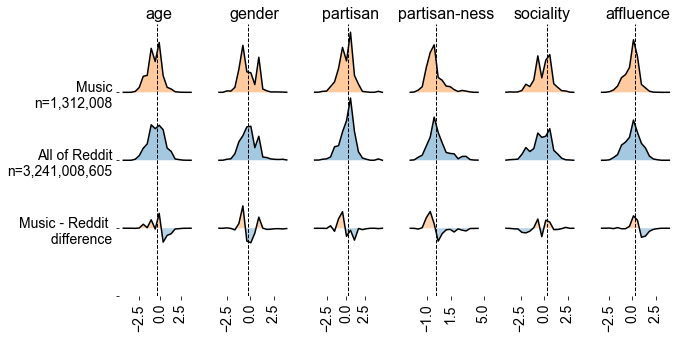

In [20]:
many_densities(groups, dimen_list, df, density_scaling_factor=0.29, figsize=[10,5], bins = 20)
plt.savefig('visuals\\music_vs_comments_difference_z4.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

In [20]:
df4['partisan-ness'].median() - ((data2['partisan-ness']*data2['num_comments'] ) / data2['num_comments'].sum()).median()

-0.06940409648757982

4.752846064992511

### Calculate the log odds ratio between the two communities

In [141]:
music = pd.read_csv(r"data\Reddit_Sub_Com_f_genre.csv")
reddit = pd.read_csv("data\\reweighted_null_counts.csv")

reddit = reddit[reddit['subreddit'].isin(music['subreddit'])]

In [142]:
music_g = music.groupby('subreddit')['artist'].count()

In [143]:
music_g2 = music_g[music_g > 100]

In [144]:
sum_music = music_g2.sum()
log_odds_music = np.log(music_g2/sum_music / (1-music_g2/sum_music))

In [145]:
reddit = reddit[reddit['subreddit'].isin(music_g2.index)]
reddit.index = reddit['subreddit']
reddit = reddit['num_comments']

sum_reddit = reddit.sum()
log_odds = np.log((music_g2/sum_music / (1-music_g2/sum_music)) /(reddit/sum_reddit / (1-reddit/sum_reddit)))

In [150]:
log_odds = log_odds.sort_values(ascending=False)

In [152]:
log_odds.to_csv("data\\log_odds_ratio.csv")

In [138]:
difference = log_odds_reddit - log_odds_music

In [139]:
difference.sort_values()

subreddit
WoahTunes              -6.398847
GuiltyPleasureMusic    -6.009501
90sAlternative         -5.840871
Alternativerock        -5.747419
runningmusic           -5.707331
                          ...   
GlobalOffensiveTrade    2.678535
MakeupAddiction         2.684271
fantasyfootball         2.706851
RocketLeagueExchange    3.255260
buildapc                3.430787
Length: 1095, dtype: float64